In [1]:
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("Linear.jl")

forward (generic function with 1 method)

# Two Parameter Linear Inverse Problems

Consider the 2-parameter linear inverse problem
$$y = G\theta + \eta.$$
with $\eta \sim \mathcal{N}(0, 0.1^2I)$. We explore the following three scenarios

* non-singular (well-determined) system (NS) 
   $$
   y = \begin{bmatrix}
        3 \\
        7 
       \end{bmatrix}~~~
       G = \begin{bmatrix}
        1 & 2\\
        3 & 4
    \end{bmatrix}~~~
    \theta_{ref} = \begin{bmatrix}
        1 \\
        1 
       \end{bmatrix};
   $$ 
   
* over-determined system (OD)

    $$
    y = \begin{bmatrix}
        3 \\
        7 \\
        10
       \end{bmatrix}~~~
       G = \begin{bmatrix}
        1 & 2\\
        3 & 4 \\
        5 & 6
    \end{bmatrix}~~~
    \theta_{ref} = \begin{bmatrix}
        1/3 \\
        17/12
       \end{bmatrix};
   $$ 
   
* under-determined system (UD)
    $$
    y = \begin{bmatrix}
        3
       \end{bmatrix}~~~
       G = \begin{bmatrix}
        1 & 2\\
    \end{bmatrix}~~~
       \theta_{ref} = \begin{bmatrix}
        1 \\
        1 
       \end{bmatrix}
       + c\begin{bmatrix}
        2 \\
        -1 
       \end{bmatrix}, \,\,c \in \mathcal{R}.
   $$
   
We define $$\displaystyle \theta_{ref} = argmin_{\theta}\frac{1}{2}\lVert\Sigma_{\eta}^{-\frac{1}{2}}(y - G\theta)\rVert^2,$$ and 
note that, in the UD case, $\theta_{ref}$ comprises a one-parameter family of possible solutions. We also note that $y = G\theta_{ref}$ for NS; and 
$y = G\theta_{ref}(c^\dagger)$ for UD, with $c^{\dagger}=0$; but for OD $y \ne  G\theta_{ref}.$ 

function Two_Param_Linear_Test(problem_type::String)
    
    N_θ = 2
    θ0_bar = zeros(Float64, N_θ)  # mean 
    θθ0_cov = Array(Diagonal(fill(0.5^2, N_θ)))     # standard deviation
    
    
    if problem_type == "square"
        # Square matrix case
        θ_ref = [1.0;1.0]
        G = [1.0 2.0; 3.0 4.0]
        
        y = [3.0;7.0]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
    
    elseif problem_type == "under-determined"
        # under-determined case
        θ_ref = [0.6, 1.2]
        G = [1.0 2.0;]
        
        y = [3.0;]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
        
    
    elseif problem_type == "over-determined"
        # over-determined case
        θ_ref = [1/3, 8.5/6]
        G = [1.0 2.0; 3.0 4.0; 5.0 6.0]
        
        y = [3.0;7.0;10.0]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
        
        
    else
        error("Problem type : ", problem_type, " has not implemented!")
    end

    return θ_ref, G, y, Σ_η
end

## Unscented Kalman Inversion

When the unscented Kalman inversion is applied with $\theta_0 \sim \mathcal{N}(0, 0.5^2I)$, 
the convergence of the $\theta$ for all three scenarios are depicted, in terms of the $L_2$ error $\lVert m_n - \theta_{ref}\rVert_2$ 
Exponential convergence is achieved!

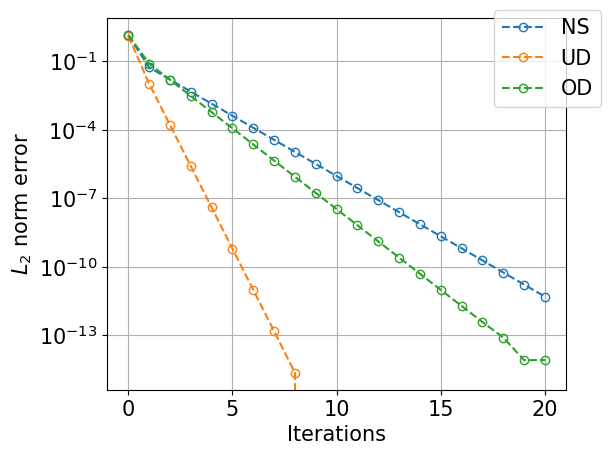

In [3]:
FT = Float64
uki_objs = Dict()
mean_errors = Dict()


α_reg = 1.0
update_freq = 0
N_iter = 20

for problem_type in ("square", "under-determined", "over-determined")
    
    θ_ref, G, y, Σ_η = Two_Param_Linear_Test(problem_type)
    
    N_θ = length(θ_ref)
    N_y = length(y)
    
    s_param = Setup_Param(G, N_θ, N_y)
    
    θ0_mean = zeros(FT, N_θ)
    θθ0_cov = Array(Diagonal(fill(0.5^2, N_θ)))
    
    
    uki_objs[problem_type] = UKI_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    y, Σ_η,
    α_reg,
    update_freq,
    N_iter)
    
    
    errors = zeros(FT, N_iter+1)
    for i = 1:N_iter+1
        errors[i] = norm(uki_objs[problem_type].θ_mean[i] .- θ_ref)
    end
    mean_errors[problem_type] = errors
end

ites = Array(0:N_iter)
semilogy(ites, mean_errors["square"], "--o", fillstyle="none", label="NS")
semilogy(ites, mean_errors["under-determined"], "--o", fillstyle="none", label="UD")
semilogy(ites, mean_errors["over-determined"], "--o", fillstyle="none", label="OD")
xlabel("Iterations")
ylabel("\$L_2\$ norm error")
grid("on")
legend(bbox_to_anchor=(1.1, 1.05))
tight_layout()